
## Check for damage car or not

### data1a - whole cars vs. all damaged cars

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model,Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [ ]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16,
                                            class_mode=None,
                                            shuffle=False)

    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [ ]:

def plot_metrics(hist, stop=50):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
  axes = axes.flatten()

  axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
  axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
  axes[0].set_title('Accuracy')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].legend(loc='lower right')

  axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
  axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
  axes[1].set_title('Loss')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(loc='upper right')

  plt.tight_layout();

  print("Best Model:")
  print_best_model_results(hist)

In [ ]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='binary',
                                shuffle=False)

    predictions = model.predict_generator(generator, len(labels))


    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [ ]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

## Defining input data

In [ ]:
# path to the model weights file
location = '/content/drive/MyDrive/data1a'
top_model_weights_path=location+'/top_model_weights.hdf5' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model.hdf5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50
batch_size = 16

In [ ]:
# do not rerun!!
save_bottleneck_features(location)

Found 1840 images belonging to 2 classes.
115/115 [==============================] - 11s 98ms/step
Found 460 images belonging to 2 classes.
29/29 [==============================] - 3s 107ms/step


In [ ]:
def train_binary_model_A_1():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model_A_1, d1a_history_A_1 = train_binary_model_A_1()

Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.8429
Epoch 1: val_accuracy improved from -inf to 0.91739, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 6ms/step - loss: 0.3780 - accuracy: 0.8429 - val_loss: 0.2229 - val_accuracy: 0.9174
Epoch 2/50
111/115 [===========================>..] - ETA: 0s - loss: 0.1533 - accuracy: 0.9341
Epoch 2: val_accuracy improved from 0.91739 to 0.91957, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9348 - val_loss: 0.2104 - val_accuracy: 0.9196
Epoch 3/50
113/115 [============================>.] - ETA: 0s - loss: 0.0698 - accuracy: 0.9845
Epoch 3: val_accuracy improved from 0.91957 to 0.93043, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 0s 4ms/step - loss: 0.0709 - accura

Best Model:
epoch: 3 , val_acc: 0.9304347634315491 , val_loss: 0.20944897830486298


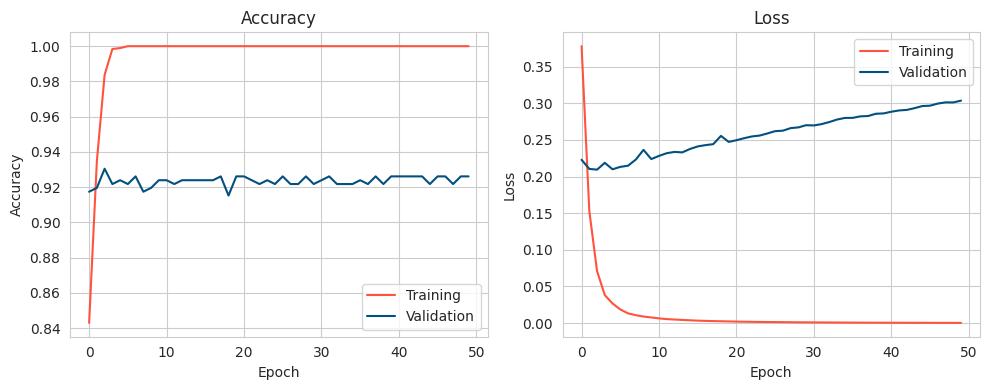

In [ ]:
plot_metrics(d1a_history_A_1) # Adam, sigmoid, no regularization

In [ ]:
def train_binary_model1():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model1, d1a_history1 = train_binary_model1()

Epoch 1/50
108/115 [===========================>..] - ETA: 0s - loss: 0.6581 - accuracy: 0.7703
Epoch 1: val_accuracy improved from -inf to 0.83696, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 10ms/step - loss: 0.6499 - accuracy: 0.7739 - val_loss: 0.4578 - val_accuracy: 0.8370
Epoch 2/50
111/115 [===========================>..] - ETA: 0s - loss: 0.3644 - accuracy: 0.8727
Epoch 2: val_accuracy improved from 0.83696 to 0.88043, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 0s 4ms/step - loss: 0.3628 - accuracy: 0.8717 - val_loss: 0.3184 - val_accuracy: 0.8804
Epoch 3/50
113/115 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9187
Epoch 3: val_accuracy improved from 0.88043 to 0.91087, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 0s 4ms/step - loss: 0.2072 - accur

Best Model:
epoch: 8 , val_acc: 0.9326087236404419 , val_loss: 0.2642398476600647


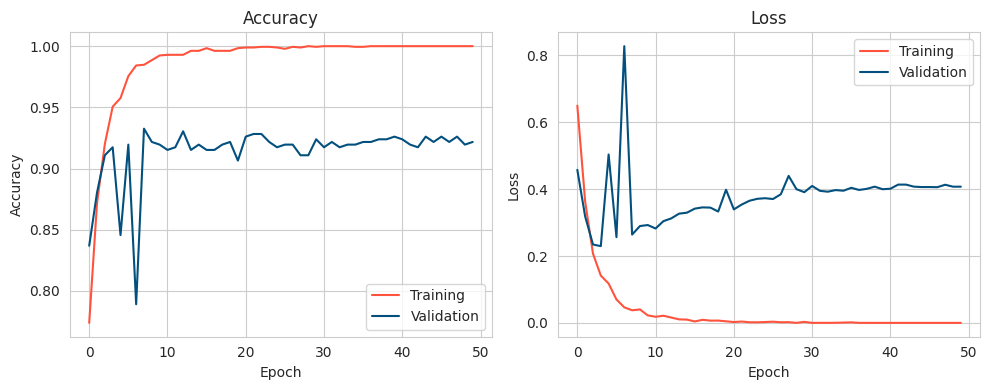

In [ ]:
plot_metrics(d1a_history1) # rmsprop, sigmoid, no regularization

In [ ]:
def train_binary_model2():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1,activation='sigmoid',kernel_regularizer='l2'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model2, d1a_history2 = train_binary_model2()

Epoch 1/50
108/115 [===========================>..] - ETA: 0s - loss: 0.4309 - accuracy: 0.8166
Epoch 1: val_accuracy improved from -inf to 0.90652, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 9ms/step - loss: 0.4307 - accuracy: 0.8185 - val_loss: 0.2428 - val_accuracy: 0.9065
Epoch 2/50
111/115 [===========================>..] - ETA: 0s - loss: 0.2171 - accuracy: 0.9285
Epoch 2: val_accuracy improved from 0.90652 to 0.91739, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 5ms/step - loss: 0.2179 - accuracy: 0.9283 - val_loss: 0.2414 - val_accuracy: 0.9174
Epoch 3/50
109/115 [===========================>..] - ETA: 0s - loss: 0.1459 - accuracy: 0.9679
Epoch 3: val_accuracy did not improve from 0.91739
115/115 [==============================] - 0s 4ms/step - loss: 0.1457 - accuracy: 0.9679 - val_loss: 0.2752 - val_accuracy: 0.9152
Epoch 4/50
109/115 [=

Best Model:
epoch: 13 , val_acc: 0.9239130616188049 , val_loss: 0.2750115990638733


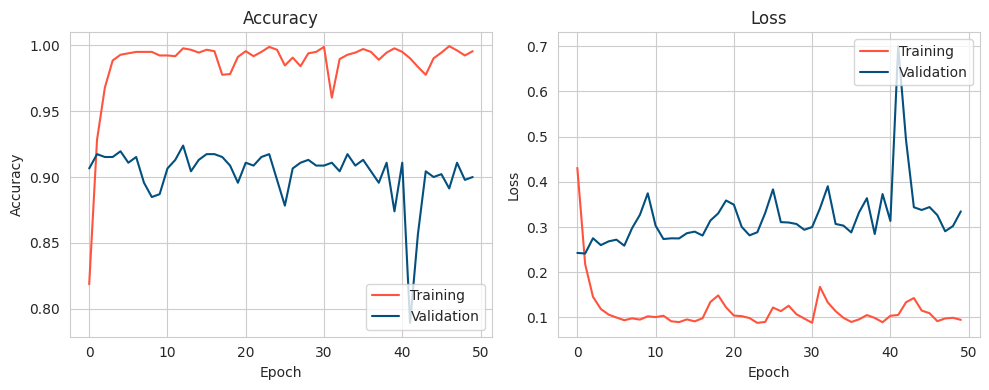

In [ ]:
plot_metrics(d1a_history2) # Adam, sigmoid, with l2 regularization (0.01)

In [ ]:
def train_binary_model_R_2():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1,activation='sigmoid',kernel_regularizer='l2'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model_R_2, d1a_history_R_2 = train_binary_model_R_2()

Epoch 1/50
108/115 [===========================>..] - ETA: 0s - loss: 0.7141 - accuracy: 0.7755
Epoch 1: val_accuracy improved from -inf to 0.77174, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 2s 14ms/step - loss: 0.6911 - accuracy: 0.7815 - val_loss: 0.6269 - val_accuracy: 0.7717
Epoch 2/50
112/115 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8700
Epoch 2: val_accuracy improved from 0.77174 to 0.90000, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 6ms/step - loss: 0.3843 - accuracy: 0.8707 - val_loss: 0.2903 - val_accuracy: 0.9000
Epoch 3/50
104/115 [==========================>...] - ETA: 0s - loss: 0.2769 - accuracy: 0.9135
Epoch 3: val_accuracy improved from 0.90000 to 0.91522, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 6ms/step - loss: 0.2860 - accur

Best Model:
epoch: 7 , val_acc: 0.9195652008056641 , val_loss: 0.29755833745002747


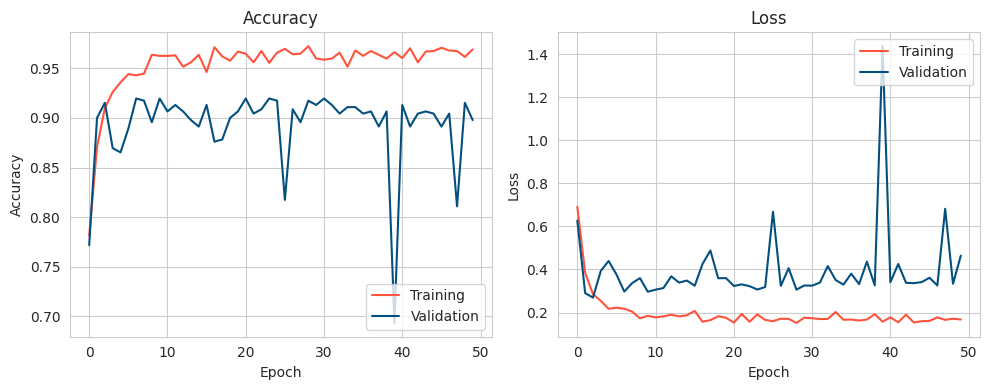

In [ ]:
plot_metrics(d1a_history_R_2) # rmsprop, sigmoid, with l2 regularization (0.01)

In [ ]:
def train_binary_model3():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model3, d1a_history3 = train_binary_model3() #dropout

Epoch 1/50
107/115 [==========================>...] - ETA: 0s - loss: 1.3298 - accuracy: 0.7471
Epoch 1: val_accuracy improved from -inf to 0.88913, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 4s 14ms/step - loss: 1.2670 - accuracy: 0.7527 - val_loss: 0.2835 - val_accuracy: 0.8891
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8272
Epoch 2: val_accuracy did not improve from 0.88913
115/115 [==============================] - 1s 7ms/step - loss: 0.4340 - accuracy: 0.8272 - val_loss: 0.3546 - val_accuracy: 0.8348
Epoch 3/50
112/115 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8571
Epoch 3: val_accuracy improved from 0.88913 to 0.91957, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 7ms/step - loss: 0.3477 - accuracy: 0.8554 - val_loss: 0.2135 - val_accuracy: 0.9196
Epoch 4/50
106/115 [

Best Model:
epoch: 24 , val_acc: 0.9326087236404419 , val_loss: 0.47559475898742676


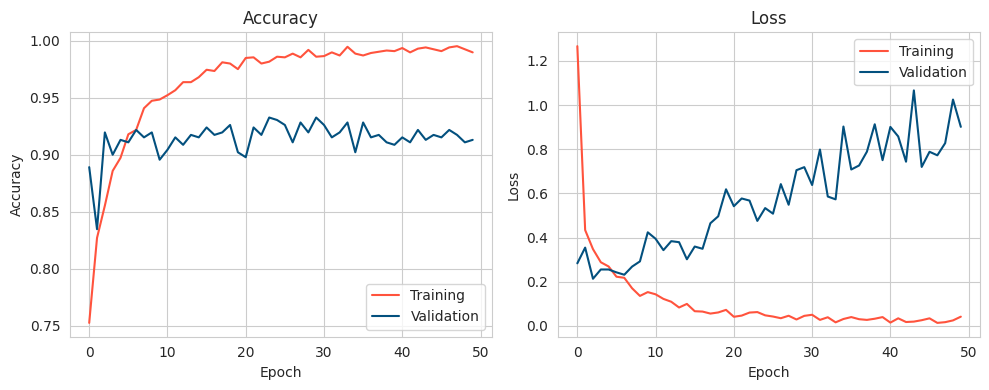

In [ ]:
plot_metrics(d1a_history3) # rmsprop, sigmoid, with double dense and dropout layers

In [ ]:
def train_binary_model4():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model4, d1a_history4 = train_binary_model4()

Epoch 1/50
103/115 [=========================>....] - ETA: 0s - loss: 1.7511 - accuracy: 0.7318
Epoch 1: val_accuracy improved from -inf to 0.85435, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 2s 17ms/step - loss: 1.6320 - accuracy: 0.7326 - val_loss: 0.3605 - val_accuracy: 0.8543
Epoch 2/50
109/115 [===========================>..] - ETA: 0s - loss: 0.6021 - accuracy: 0.7827
Epoch 2: val_accuracy did not improve from 0.85435
115/115 [==============================] - 1s 7ms/step - loss: 0.5902 - accuracy: 0.7848 - val_loss: 0.3344 - val_accuracy: 0.8543
Epoch 3/50
109/115 [===========================>..] - ETA: 0s - loss: 0.5203 - accuracy: 0.8114
Epoch 3: val_accuracy improved from 0.85435 to 0.87174, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 8ms/step - loss: 0.5125 - accuracy: 0.8147 - val_loss: 0.3436 - val_accuracy: 0.8717
Epoch 4/50
110/115 [

Best Model:
epoch: 26 , val_acc: 0.928260862827301 , val_loss: 0.4415731132030487


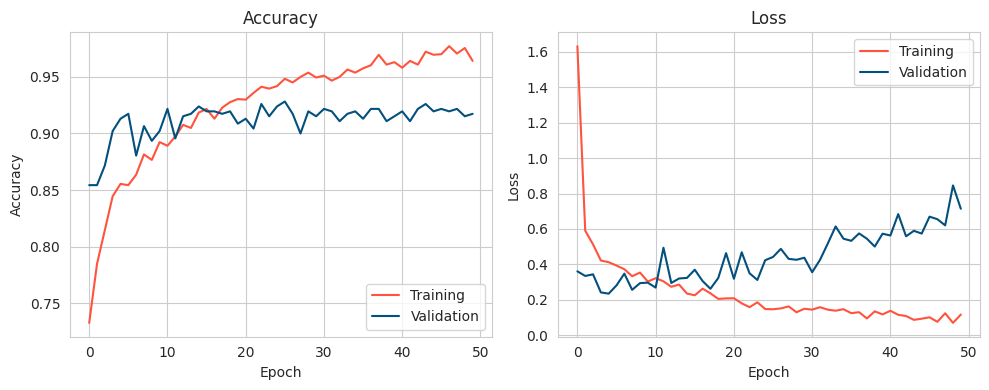

In [ ]:
plot_metrics(d1a_history4) # rmsprop, sigmoid, with aggresive dropout (.75)

In [ ]:
def train_binary_model5():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model5, d1a_history5 = train_binary_model5()

Epoch 1/50
113/115 [============================>.] - ETA: 0s - loss: 1.9093 - accuracy: 0.7423
Epoch 1: val_accuracy improved from -inf to 0.89348, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 3s 17ms/step - loss: 1.8967 - accuracy: 0.7408 - val_loss: 0.4670 - val_accuracy: 0.8935
Epoch 2/50
114/115 [============================>.] - ETA: 0s - loss: 0.6181 - accuracy: 0.8268
Epoch 2: val_accuracy did not improve from 0.89348
115/115 [==============================] - 1s 5ms/step - loss: 0.6165 - accuracy: 0.8272 - val_loss: 0.4055 - val_accuracy: 0.8717
Epoch 3/50
107/115 [==========================>...] - ETA: 0s - loss: 0.4809 - accuracy: 0.8499
Epoch 3: val_accuracy did not improve from 0.89348
115/115 [==============================] - 1s 6ms/step - loss: 0.4653 - accuracy: 0.8565 - val_loss: 0.4417 - val_accuracy: 0.8739
Epoch 4/50
106/115 [==========================>...] - ETA: 0s - loss: 0.4408 - accuracy: 0.863

Best Model:
epoch: 50 , val_acc: 0.9217391014099121 , val_loss: 0.3914857506752014


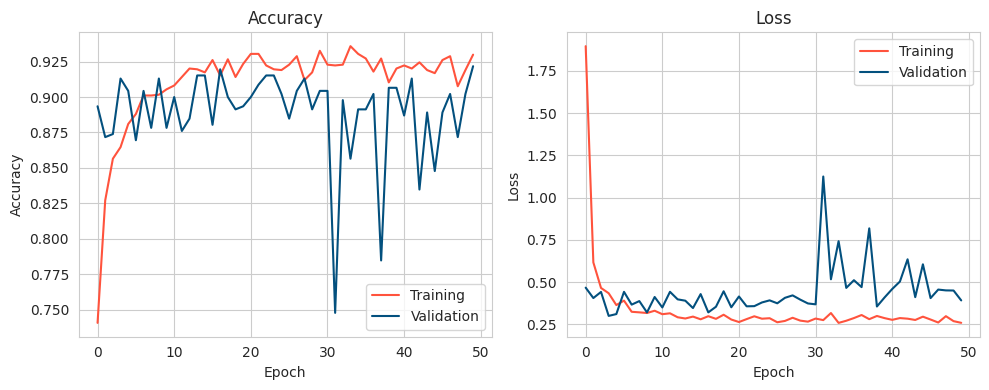

In [ ]:
plot_metrics(d1a_history5) # rmsprop, sigmoid, with l2 = 0.001

In [ ]:
def train_binary_model6():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model6, d1a_history6 = train_binary_model6()

Epoch 1/50
111/115 [===========================>..] - ETA: 0s - loss: 1.0109 - accuracy: 0.7686
Epoch 1: val_accuracy improved from -inf to 0.87174, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 2s 18ms/step - loss: 1.0081 - accuracy: 0.7685 - val_loss: 0.8334 - val_accuracy: 0.8717
Epoch 2/50
114/115 [============================>.] - ETA: 0s - loss: 0.9102 - accuracy: 0.8251
Epoch 2: val_accuracy improved from 0.87174 to 0.89565, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 7ms/step - loss: 0.9102 - accuracy: 0.8250 - val_loss: 0.7919 - val_accuracy: 0.8957
Epoch 3/50
110/115 [===========================>..] - ETA: 0s - loss: 0.8500 - accuracy: 0.8506
Epoch 3: val_accuracy improved from 0.89565 to 0.90217, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 7ms/step - loss: 0.8491 - accur

Best Model:
epoch: 45 , val_acc: 0.917391300201416 , val_loss: 0.6519611477851868


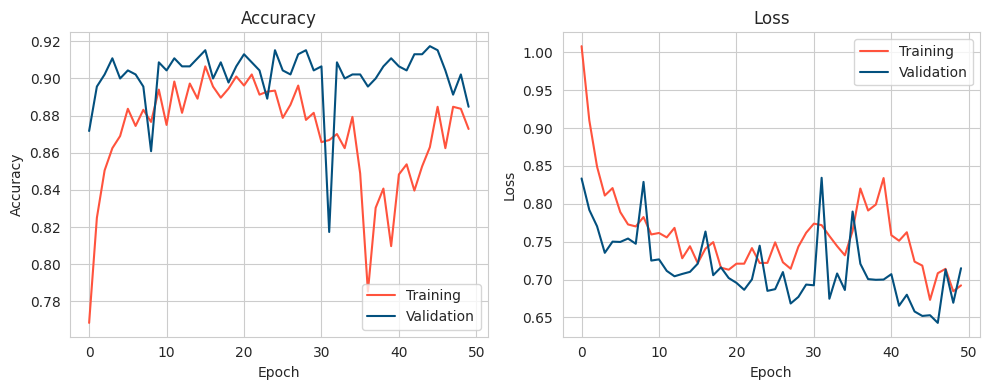

In [ ]:
plot_metrics(d1a_history6) # sgd with lr = 0.001 and decay 1e-6, sigmoid, with l2 = 0.001

In [ ]:
def train_binary_model7():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1a_model7, d1a_history7 = train_binary_model7()

Epoch 1/50
106/115 [==========================>...] - ETA: 0s - loss: 1.1355 - accuracy: 0.6840
Epoch 1: val_accuracy improved from -inf to 0.84565, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 2s 16ms/step - loss: 1.1193 - accuracy: 0.6940 - val_loss: 0.9233 - val_accuracy: 0.8457
Epoch 2/50
106/115 [==========================>...] - ETA: 0s - loss: 0.9437 - accuracy: 0.8042
Epoch 2: val_accuracy improved from 0.84565 to 0.88043, saving model to /content/drive/MyDrive/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 6ms/step - loss: 0.9368 - accuracy: 0.8103 - val_loss: 0.8535 - val_accuracy: 0.8804
Epoch 3/50
113/115 [============================>.] - ETA: 0s - loss: 0.8894 - accuracy: 0.8473
Epoch 3: val_accuracy did not improve from 0.88043
115/115 [==============================] - 1s 6ms/step - loss: 0.8895 - accuracy: 0.8467 - val_loss: 0.8142 - val_accuracy: 0.8804
Epoch 4/50
112/115 [

Best Model:
epoch: 28 , val_acc: 0.9217391014099121 , val_loss: 0.7235689163208008


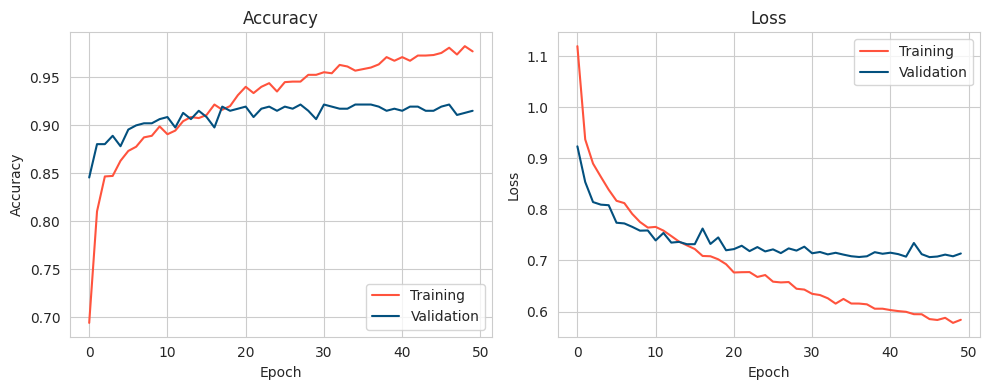

In [ ]:
#Best model
plot_metrics(d1a_history7) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Fine Tuning

In [ ]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))


    for layer in model.layers[:15]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(learning_rate=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=batch_size,
                                                           class_mode='binary')


    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True, mode='max')
    # fine-tune the model
    fit = model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=nb_epoch,
                              batch_size=batch_size,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size,
                              verbose=1,
                              callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:




ft_model, ft_history = finetune_binary_model()

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 5.7674 - accuracy: 0.6995
Epoch 1: val_accuracy improved from -inf to 0.92188, saving model to /content/drive/MyDrive/data1a/ft_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 55s 432ms/step - loss: 5.7674 - accuracy: 0.6995 - val_loss: 5.2474 - val_accuracy: 0.9219
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 5.7862 - accuracy: 0.7016
Epoch 2: val_accuracy did not improve from 0.92188
115/115 [==============================] - 45s 393ms/step - loss: 5.7862 - accuracy: 0.7016 - val_loss: 5.2367 - val_accuracy: 0.9219
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 5.7719 - accuracy: 0.7027
Epoch 3: val_accuracy did not improve from 0.92188
115/115 [==============================] - 47s 410ms/step - loss: 5.7719 - accuracy: 0.7027 - val_loss: 5.2480 - val_accuracy: 0.9219
Epoch 4/50
115/115 [==============================] - ETA: 0s - loss: 5.7714 - accuracy: 0.7054
Epoch 4: val_accuracy did not improve from 0.92188
115/115 [==============================] - 45s 390ms/step - loss: 5.7714 - accuracy: 0.7054 - val_loss: 5.2464 - val_accuracy: 0.9219
Epoch 5/50
115/115 [===

Best Model:
epoch: 33 , val_acc: 0.9308035969734192 , val_loss: 5.2285685539245605


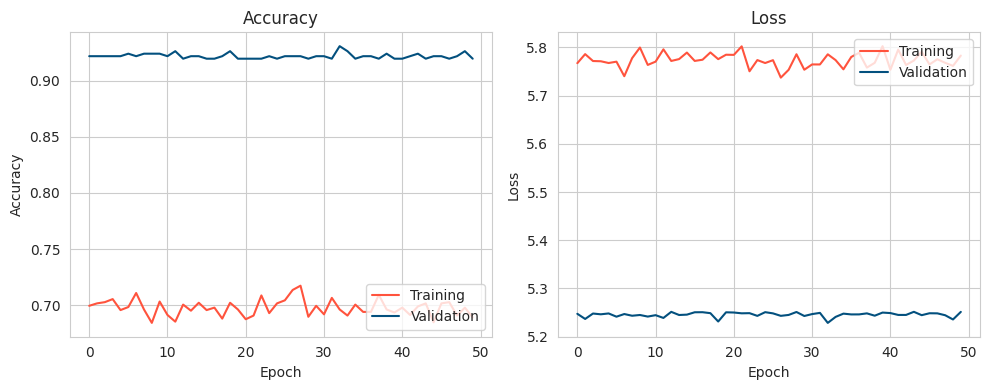

In [ ]:
# Best model
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Load Model Point

In [ ]:
ft_model = load_model(location+'/ft_model.hdf5')

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming ft_model is your trained model
ft_model.save(location+'/first_model.hdf5')


In [ ]:
from tensorflow.keras.models import save_model

# Assuming ft_model is your trained model
save_model(ft_model, location+'/first_model_saved_model')


In [ ]:
with open(location+'/top_history.txt') as f:
    top_history = json.load(f)

In [ ]:
from tensorflow.keras.models import load_model

ft1_model = load_model(location+'/first_model_saved_model')


In [ ]:
with open(location+'/ft_history.txt') as f:
    ft_history = json.load(f)

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout();

In [ ]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary',
                                shuffle=False)

    predictions = model.predict_generator(generator, len(labels))

    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

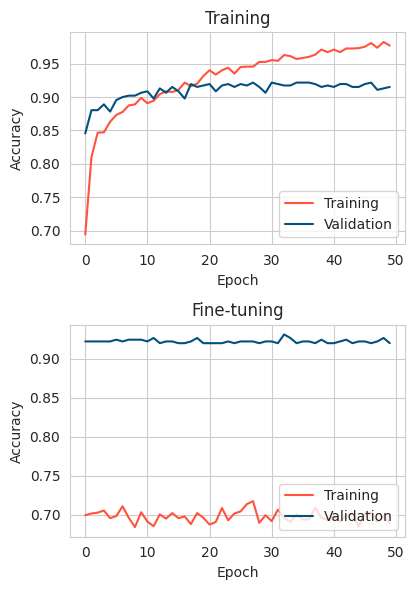

In [ ]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 33 , val_acc: 0.9308035969734192 , val_loss: 5.2285685539245605


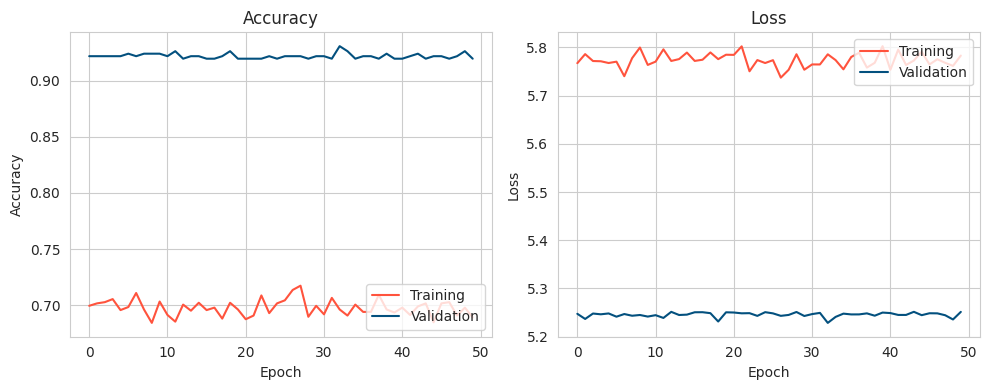

In [ ]:
# Best Model
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [ ]:
validation_labels = np.array([0] * validation_samples[0] +
                             [1] * validation_samples[1])

Found 460 images belonging to 2 classes.


<ipython-input-6-d03229e66d80>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, len(labels))



              precision    recall  f1-score   support

           0       0.89      0.96      0.92       230
           1       0.95      0.89      0.92       230

    accuracy                           0.92       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.92      0.92      0.92       460




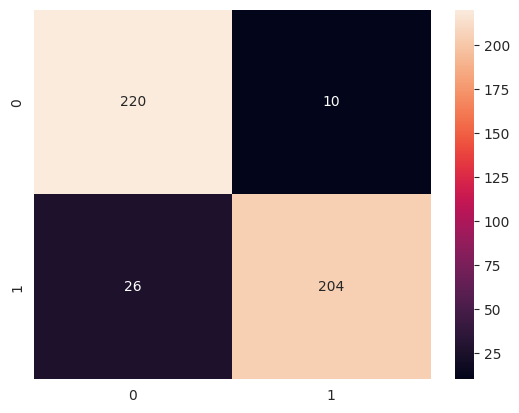

In [ ]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

## Making Live Predictions

In [ ]:
from urllib.request import urlretrieve

def car_categories_gate(image_path, model,option=1):
    if(option==1):
      urlretrieve(image_path, 'save.jpg')
      img = load_img('save.jpg', target_size=(256, 256))
    else:
      img = load_img(image_path, target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists...")
    print(pred)
    if pred[0][0] <=.5:

        print("Validation complete - proceed to location and severity determination")
    else:
        print("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print("Hint: Try zooming in/out, using a different angle or different lighting")

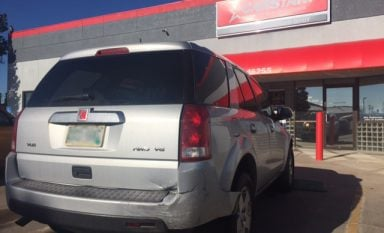

In [ ]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [ ]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

1/1 [==============================] - 1s 1s/step
Validating that damage exists...
[[0.11168591]]
Validation complete - proceed to location and severity determination


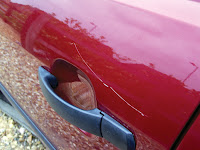

In [ ]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [ ]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

1/1 [==============================] - 0s 17ms/step
Validating that damage exists...
[[0.1701055]]
Validation complete - proceed to location and severity determination


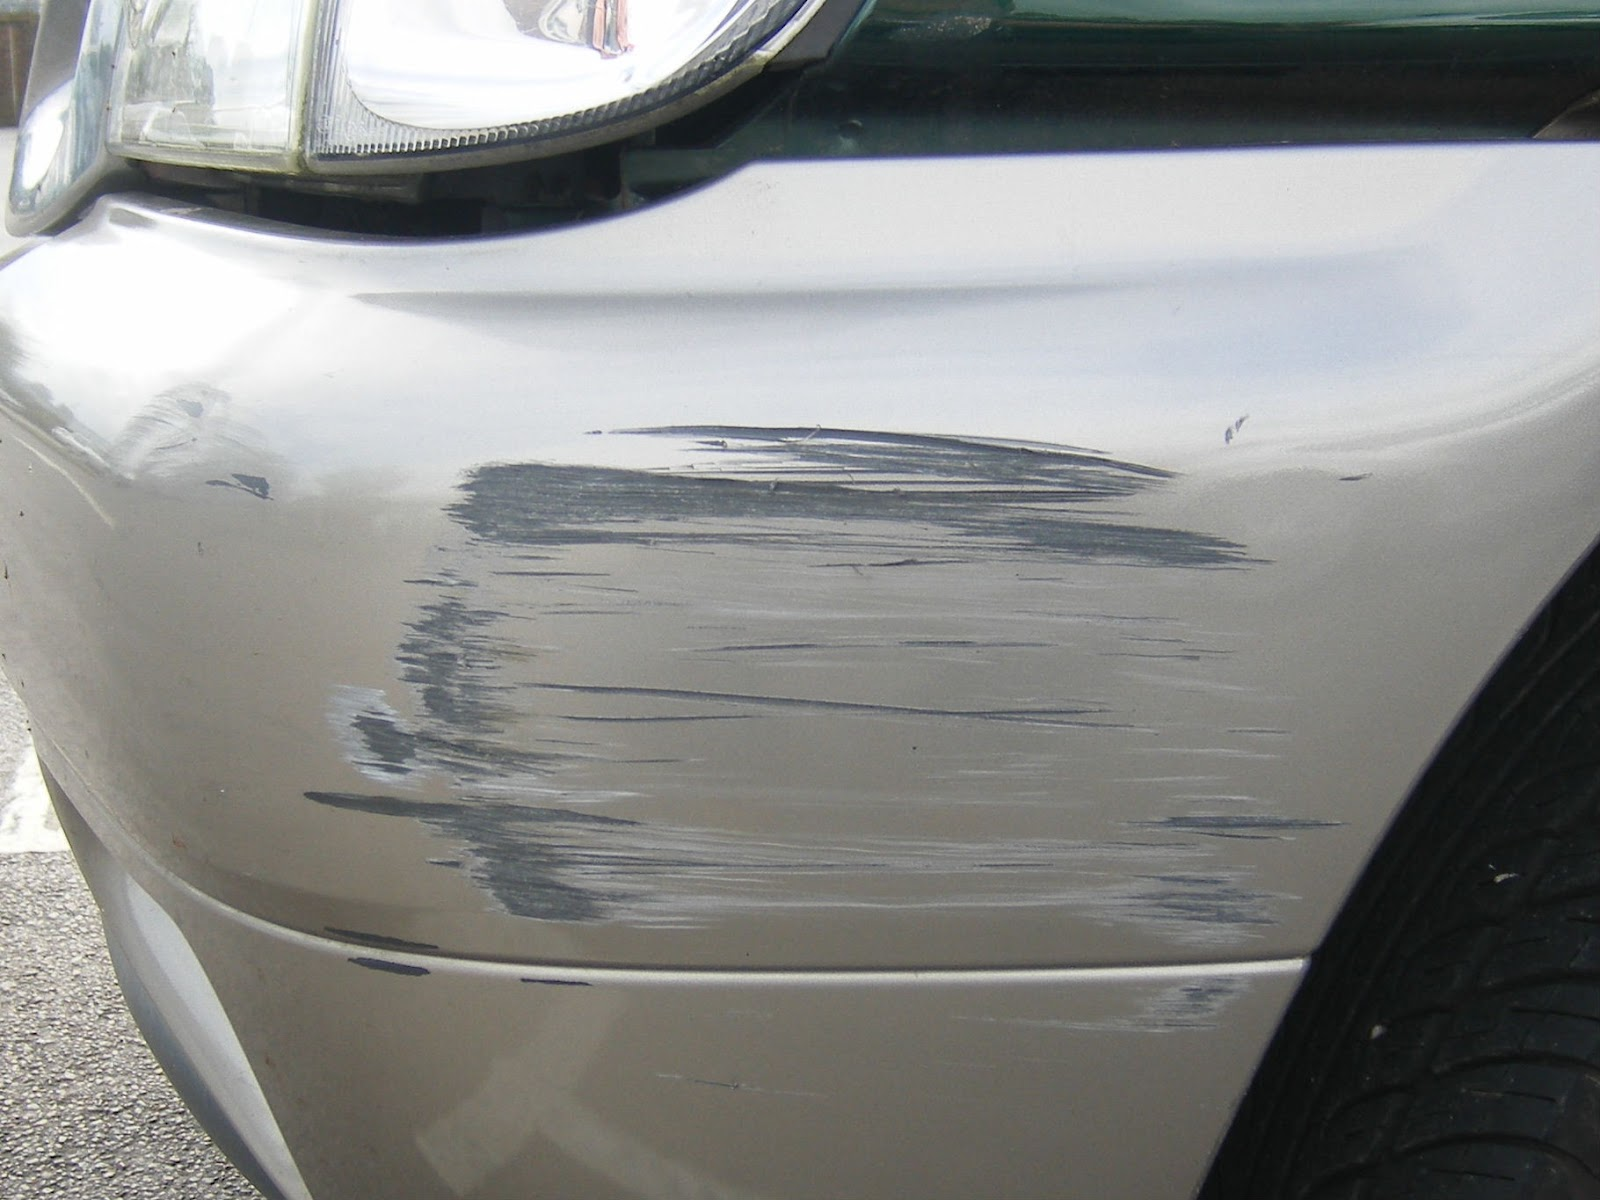

In [ ]:
Image('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG')

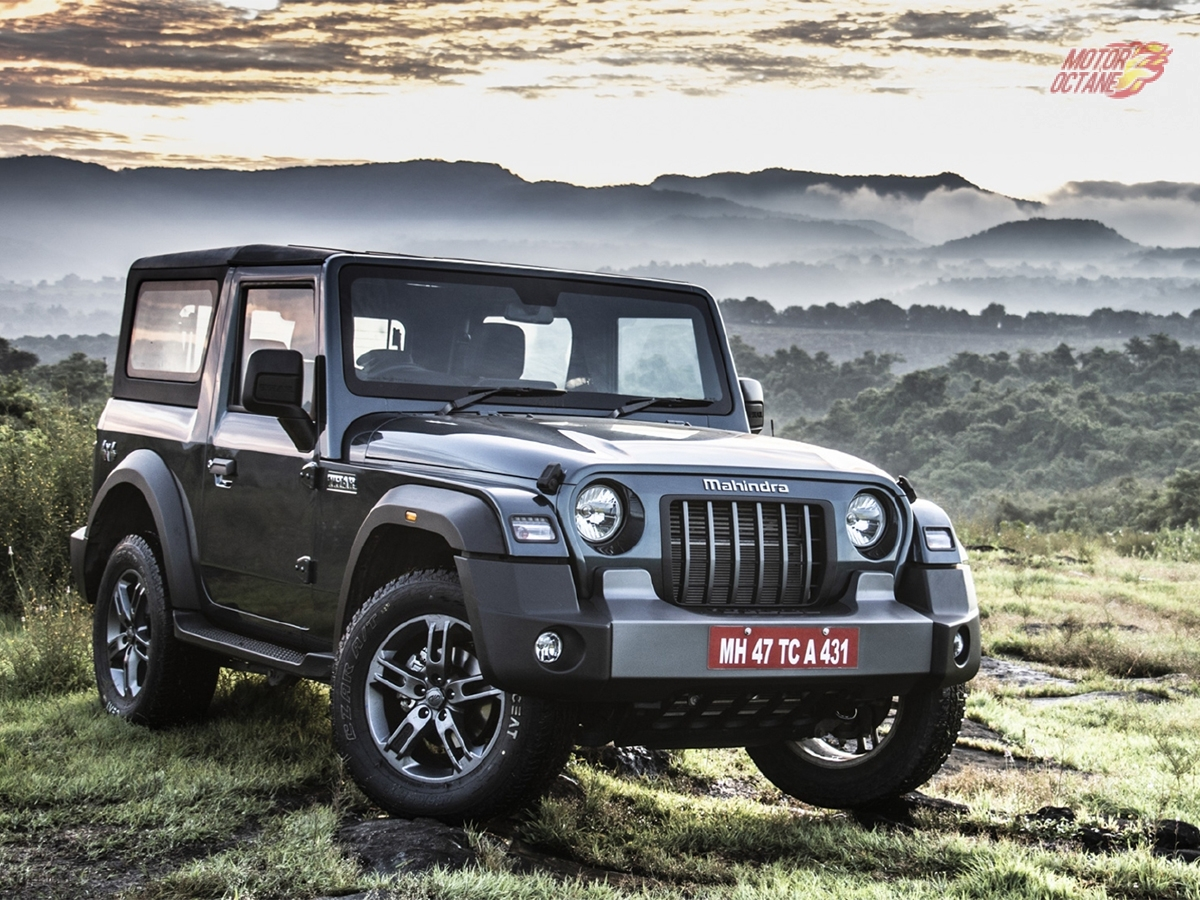

In [ ]:
Image('/content/Mahindra-Thar-2.jpg')

In [ ]:
car_categories_gate('/content/Mahindra-Thar-2.jpg', ft_model,0)

1/1 [==============================] - 0s 29ms/step
Validating that damage exists...
[[0.9872671]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


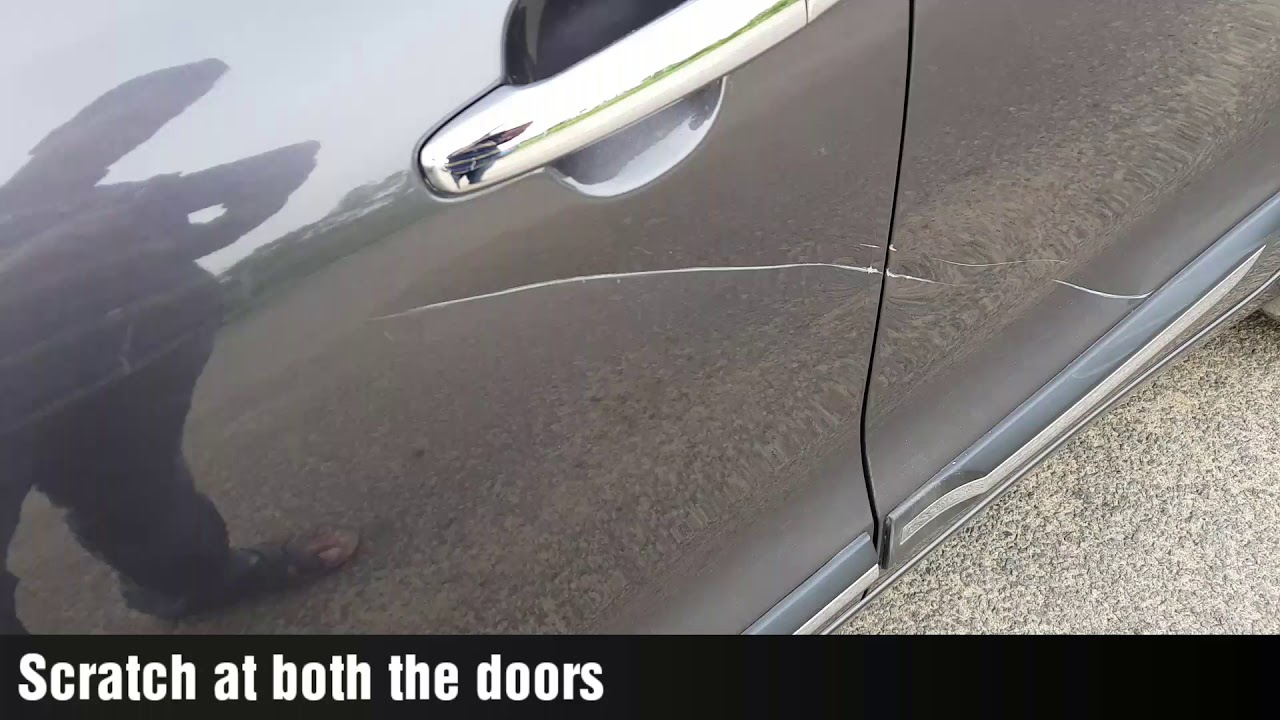

In [ ]:
Image('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg')

In [ ]:
car_categories_gate('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg', ft_model)

1/1 [==============================] - 0s 19ms/step
Validating that damage exists...
[[0.09605168]]
Validation complete - proceed to location and severity determination


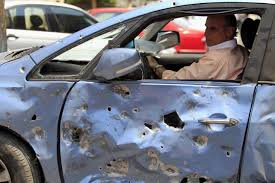

In [ ]:
Image(location+'/validation/00-damage/0010.JPEG')

In [ ]:
car_categories_gate(location+'/validation/00-damage/0005.JPEG', ft_model,0)

1/1 [==============================] - 0s 18ms/step
Validating that damage exists...
[[0.03251143]]
Validation complete - proceed to location and severity determination


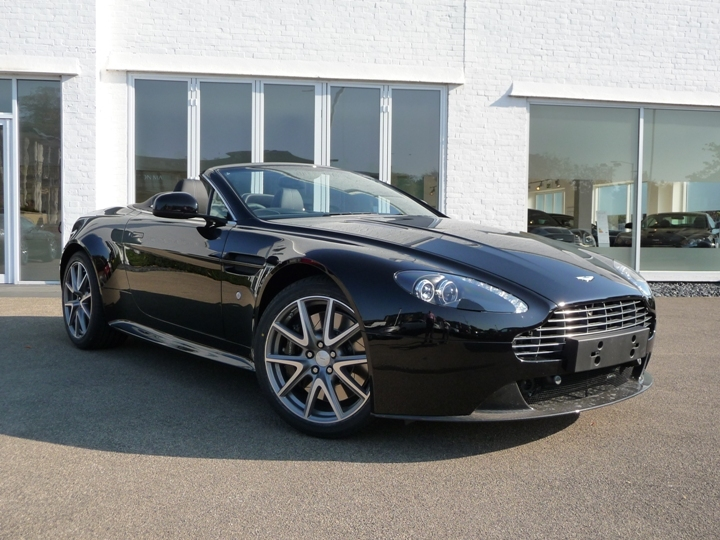

In [ ]:
Image(location+'/validation/01-whole/0010.jpg')

In [ ]:
car_categories_gate(location+'/validation/01-whole/0010.jpg', ft_model,0)

1/1 [==============================] - 0s 18ms/step
Validating that damage exists...
[[0.9740293]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting
